In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
np.random.seed(42)
%matplotlib inline

In [2]:
data_dir = '/Users/mbedell/python/pmodes/experiments/data/'
import utils

In [3]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_all = np.copy(d['ts'])
rvs_all = np.copy(d['rvs'])
xs_all = np.copy(d['xs'])

In [4]:
time_per_night = 45. * 60. # seconds
nights_per_year = 60
integrated_kernel = False # for the > 1 minute exposures only

#### observe for N consecutive 1-min integrations every night

In [5]:
start_ts = np.arange(30,30+nights_per_year) * 3600. * 24. # nightly on consecutive nights
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [6]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 0.5

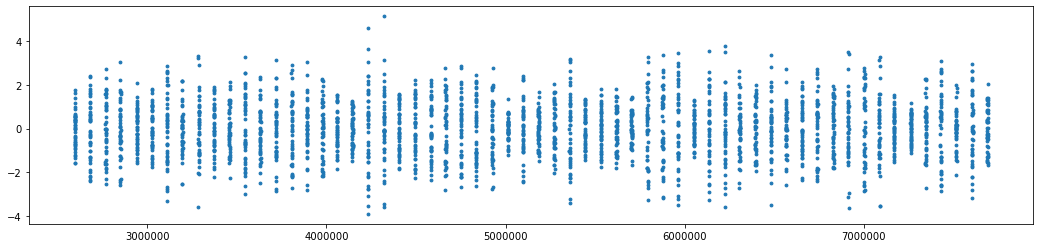

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(t, y, s=8);

In [8]:
t_grid = utils.make_t_grid(start_ts, time_per_night)

In [9]:
map_soln, mu, sd, y_pred = utils.gp_fit(t, y, yerr, t_grid, integrated=False)    
print(map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
138it [00:00, 237.08it/s, logp=-2.294844e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: -2468.0002040037357 -> -2294.8444309167


{'logS0': array(1.27850548), 'logw0': array(-3.92464635), 'logQ': array(3.07074561)}


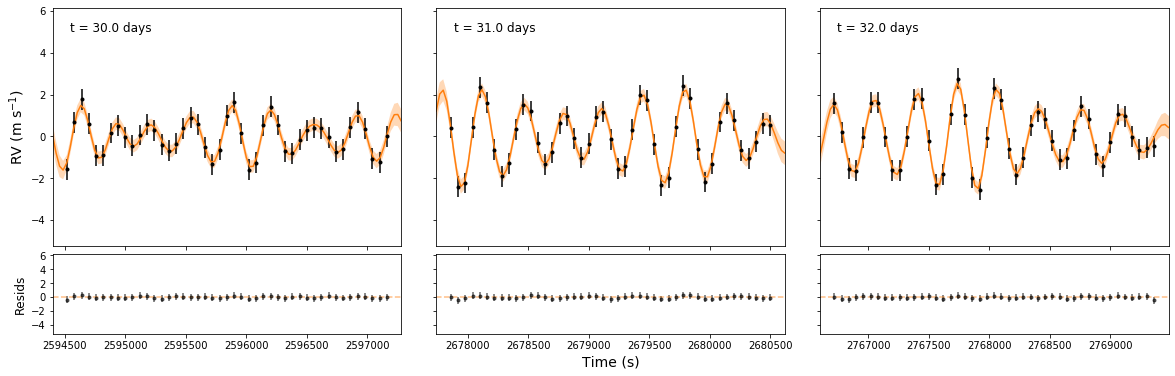

In [10]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd, time_per_night=time_per_night)

In [11]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 0.15 m/s


#### N consecutive observations per night, but random nights

In [12]:
start_ts = np.random.choice(360, nights_per_year, replace=False) * 3600. * 24. # nightly for random nights (we're gonna ignore seasons)
start_ts += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
start_ts.sort()
assert np.isin(start_ts, ts_all).all(), "Bad timestamp!"

In [13]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 0.5

In [14]:
t_grid = utils.make_t_grid(start_ts, time_per_night)

In [15]:
map_soln, mu, sd, y_pred = utils.gp_fit(t, y, yerr, t_grid, integrated=False)    
print(map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
18it [00:00, 470.63it/s, logp=-2.274821e+03]
message: Optimization terminated successfully.
logp: -2521.1689911496846 -> -2274.8207611311473


{'logS0': array(1.29921365), 'logw0': array(-3.93785726), 'logQ': array(2.95898093)}


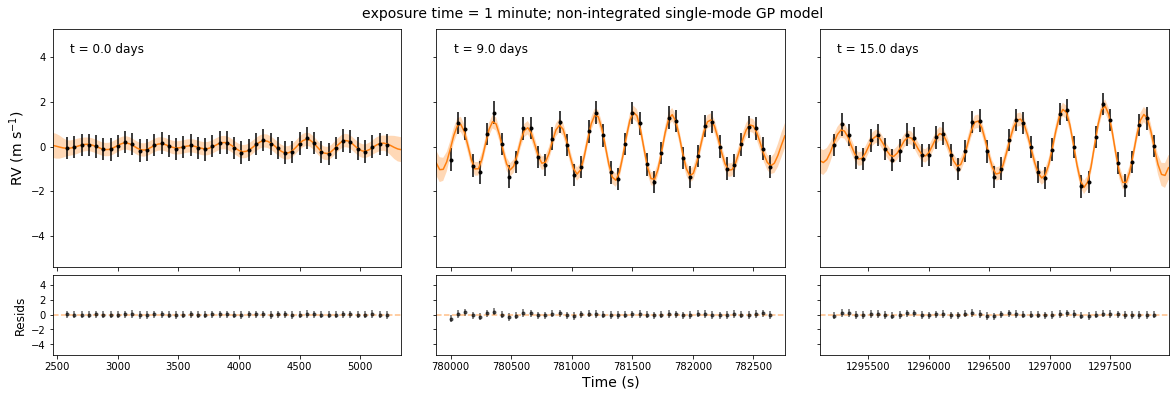

In [16]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd, time_per_night=time_per_night)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated.png');

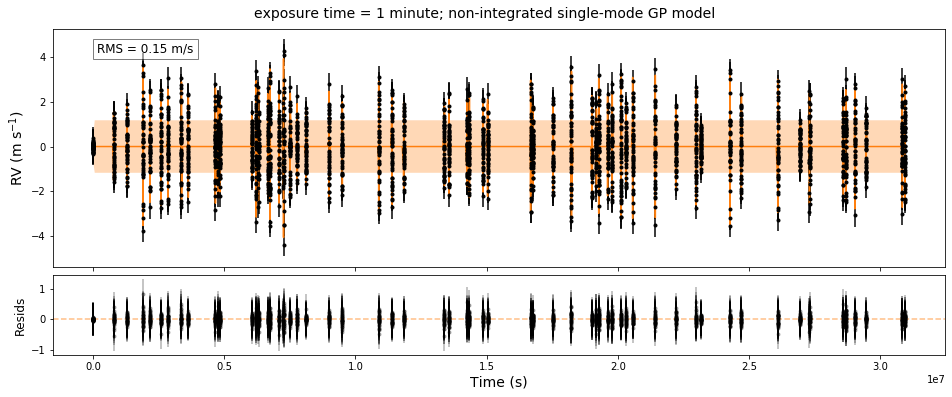

In [17]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated_full.png');

#### random nights, longer exposures

In [18]:
exp_time = 3. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)

t = []
y = []

for st in start_ts:
    inds = (ts_all > st - 1800.) & (ts_all < st + time_per_night + 1800.)
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], stt, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)
yerr = np.zeros_like(t) + 0.5 / np.sqrt(exp_time/60.)

In [19]:
t_grid = utils.make_t_grid(start_ts, time_per_night)

In [20]:
map_soln, mu, sd, y_pred = utils.gp_fit(t, y, yerr, t_grid,
                                        integrated=integrated_kernel, exp_time=exp_time)      
print(map_soln)

# 3-min non-integrated: {'logS0': array(0.26488849), 'logw0': array(-4.12446973), 'logQ': array(2.92363189)}
# 3-min non-integrated with scaled-down errors: {'logS0': array(0.06071846), 'logw0': array(-3.95259095), 'logQ': array(3.10488044)}
# 3-min integrated: {'logS0': array(0.77391424), 'logw0': array(-4.12053392), 'logQ': array(3.14345626)}
# 3-min non-integrated with scaled-down errors: fails, returns starting parameters
# 5-min integrated: goes flat

optimizing logp for variables: [logQ, logw0, logS0]
17it [00:00, 661.02it/s, logp=-4.393682e+02]
message: Optimization terminated successfully.
logp: -556.0831393592216 -> -439.3681796637944


{'logS0': array(0.06071846), 'logw0': array(-3.95259095), 'logQ': array(3.10488044)}


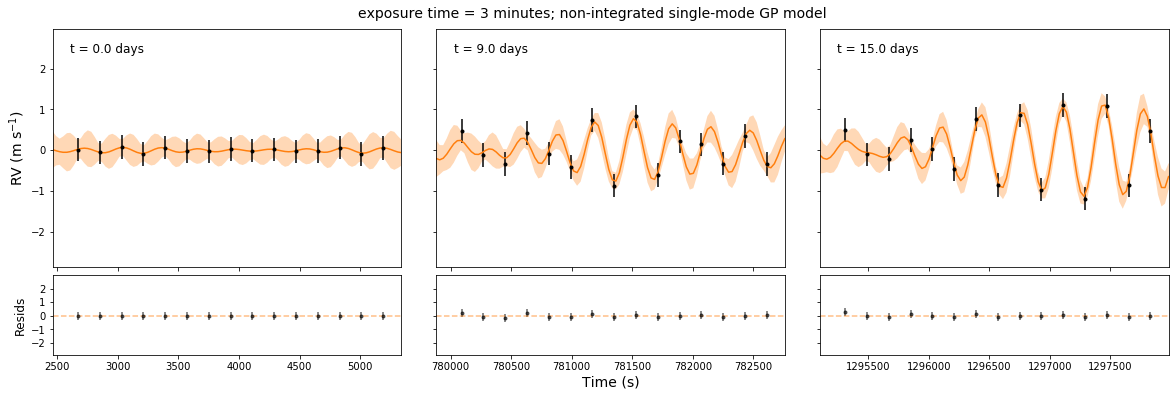

In [21]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts, t_grid, mu, sd, time_per_night=time_per_night)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_integrated.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

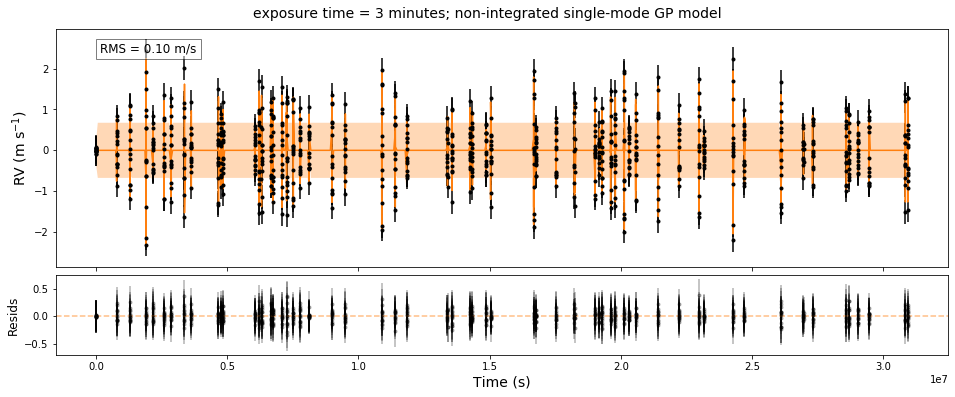

In [22]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts, t_grid, mu, sd)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_integrated_full.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_nonintegrated_full.png'.format(exp_time/60.));